In [1]:
from astropy.io import fits
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
hdulist = fits.open('data/allStarLite-dr17-synspec_rev1.fits')


In [3]:

hdu1_data = hdulist[1].data


In [4]:
df4 = pd.DataFrame(hdu1_data.tolist(), columns=hdu1_data.names)

In [5]:
df = df4

In [6]:
df = df.drop_duplicates(subset='APOGEE_ID')

In [7]:
df_classes = pd.read_csv('data/classes.csv')

In [8]:
df_merged = pd.merge(df_classes, df, left_on='apogee_id', right_on='APOGEE_ID', how='inner')

In [9]:
df = df_merged

In [10]:
physical_subset = df[["J", "H", "K","LOGG", "M_H", "VMICRO", "VMACRO", "VSINI"]]

In [11]:
physical_subset.describe()

,J,H,K,LOGG,M_H,VMICRO,VMACRO,VSINI
count,594011.000000,594011.000000,594011.000000,594011.000000,570430.000000,594011.000000,594011.000000,275988.000000
mean,11.349925,10.771738,10.618024,3.164193,-0.211106,1.090619,1.935201,9.584943
std,1.262613,1.195594,1.190760,1.137943,0.353422,0.590801,1.979479,19.116064
min,7.912000,7.623000,7.711000,0.509685,-2.468600,0.299999,0.000000,1.499996
25%,10.494000,9.972000,9.822000,2.377383,-0.376550,0.481903,0.000000,1.530841
50%,11.388000,10.844000,10.705000,3.067131,-0.163025,1.153873,2.578886,2.984661
75%,12.264000,11.614000,11.441000,4.311884,0.017015,1.467033,3.465211,6.671331
max,14.772000,13.643000,13.245000,4.678965,0.968570,4.799986,12.765858,96.006363


In [12]:
# subset all chemical abundances (collumn name contain "_FE")
chemical_subset = df.filter(regex='_FE', axis=1) 

# merge with + df.filter(regex='_H', axis=1)
chemical_subset = pd.concat([chemical_subset, df.filter(regex='_H', axis=1)], axis=1)

In [13]:
low_variability_columns = []

for col in df.columns:
    try:
        # Si la colonne contient moins de 5 valeurs uniques, on l'ajoute à la liste
        if df[col].nunique() < 5:
            low_variability_columns.append(col)
    except TypeError:
        print(f"error with column {col}")

print("Colonnes avec faible variabilité :", low_variability_columns)



error with column PARAMFLAG
error with column X_H
error with column X_H_ERR
error with column X_M
error with column X_M_ERR
error with column ELEM_CHI2
error with column ELEMFRAC
error with column X_H_SPEC
error with column X_M_SPEC
Colonnes avec faible variabilité : ['TELESCOPE', 'ALT_ID', 'APOGEE2_TARGET4', 'RV_ALPHA', 'RV_CARB', 'RV_FLAG', 'N_COMPONENTS', 'MAX_JK', 'P_FE', 'P_FE_SPEC', 'CU_FE', 'CU_FE_SPEC']


In [14]:
# create an error dataset containing all errors 
chemical_errors_subset = chemical_subset.filter(regex='_ERR', axis=1)

# create an error dataset containing all specs
chemical_specs_subset = chemical_subset.filter(regex='_SPEC', axis=1)

# create a dataset containing all the flags
flags_subset = chemical_subset.filter(regex='FLAG', axis=1)

# remove flags, err and spec from the chemical_subset
chemical_subset = chemical_subset.drop(chemical_errors_subset.columns, axis=1)
chemical_subset = chemical_subset.drop(chemical_specs_subset.columns, axis=1)
chemical_subset = chemical_subset.drop(flags_subset.columns, axis=1)






In [15]:
chemical_subset = chemical_subset.drop(columns=['GAIAEDR3_R_HI_GEO', 'GAIAEDR3_R_HI_PHOTOGEO'])
chemical_subset = chemical_subset.drop(columns=['MAX_H', 'MIN_H', 'M_H', 'X_H', 'RV_FEH'])

In [16]:
chemical_subset = chemical_subset.drop(columns=['P_FE', 'CU_FE'])

In [17]:
chemical_specs_subset = chemical_specs_subset.drop(columns=['X_H_SPEC'])

In [18]:
# Limiter les valeurs extrêmes pour mieux voir les distributions principales
chemical_subset_filtered = chemical_subset.apply(lambda x: x.clip(lower=x.quantile(0.01), upper=x.quantile(0.99)))

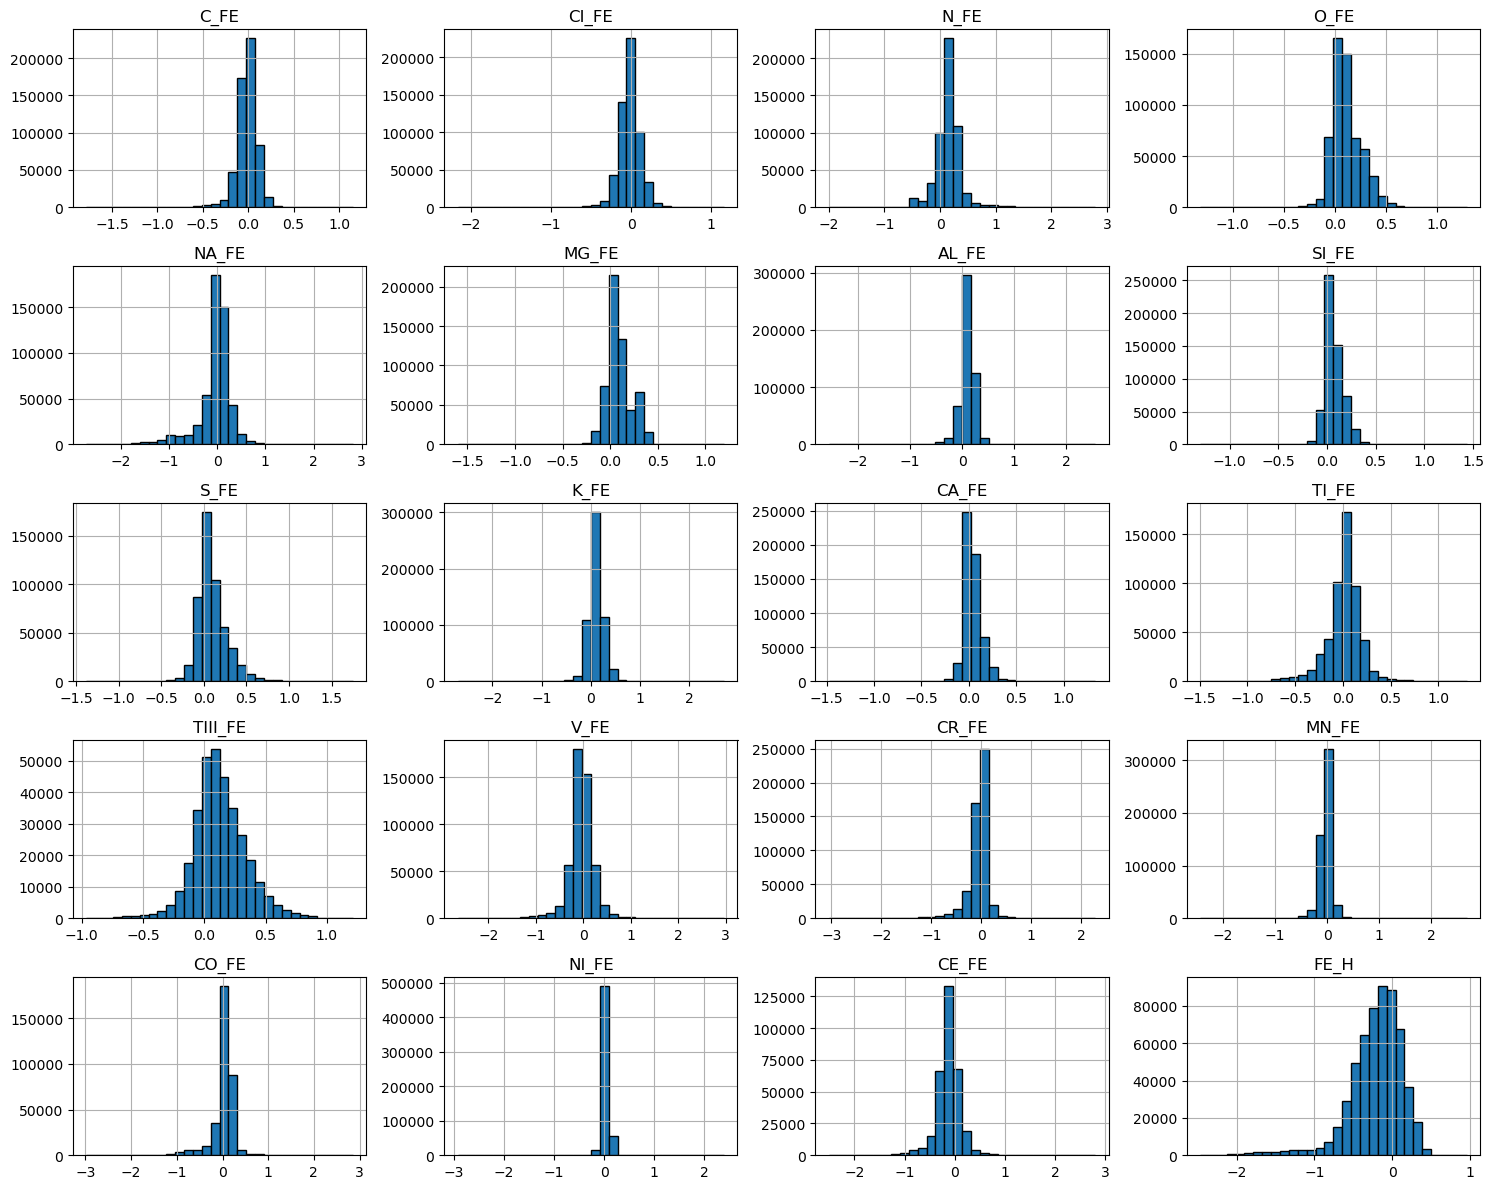

In [19]:
chemical_subset.hist(figsize=(15, 12), bins=30, edgecolor='black')
plt.tight_layout()
plt.show()


## Box plots (filtré)

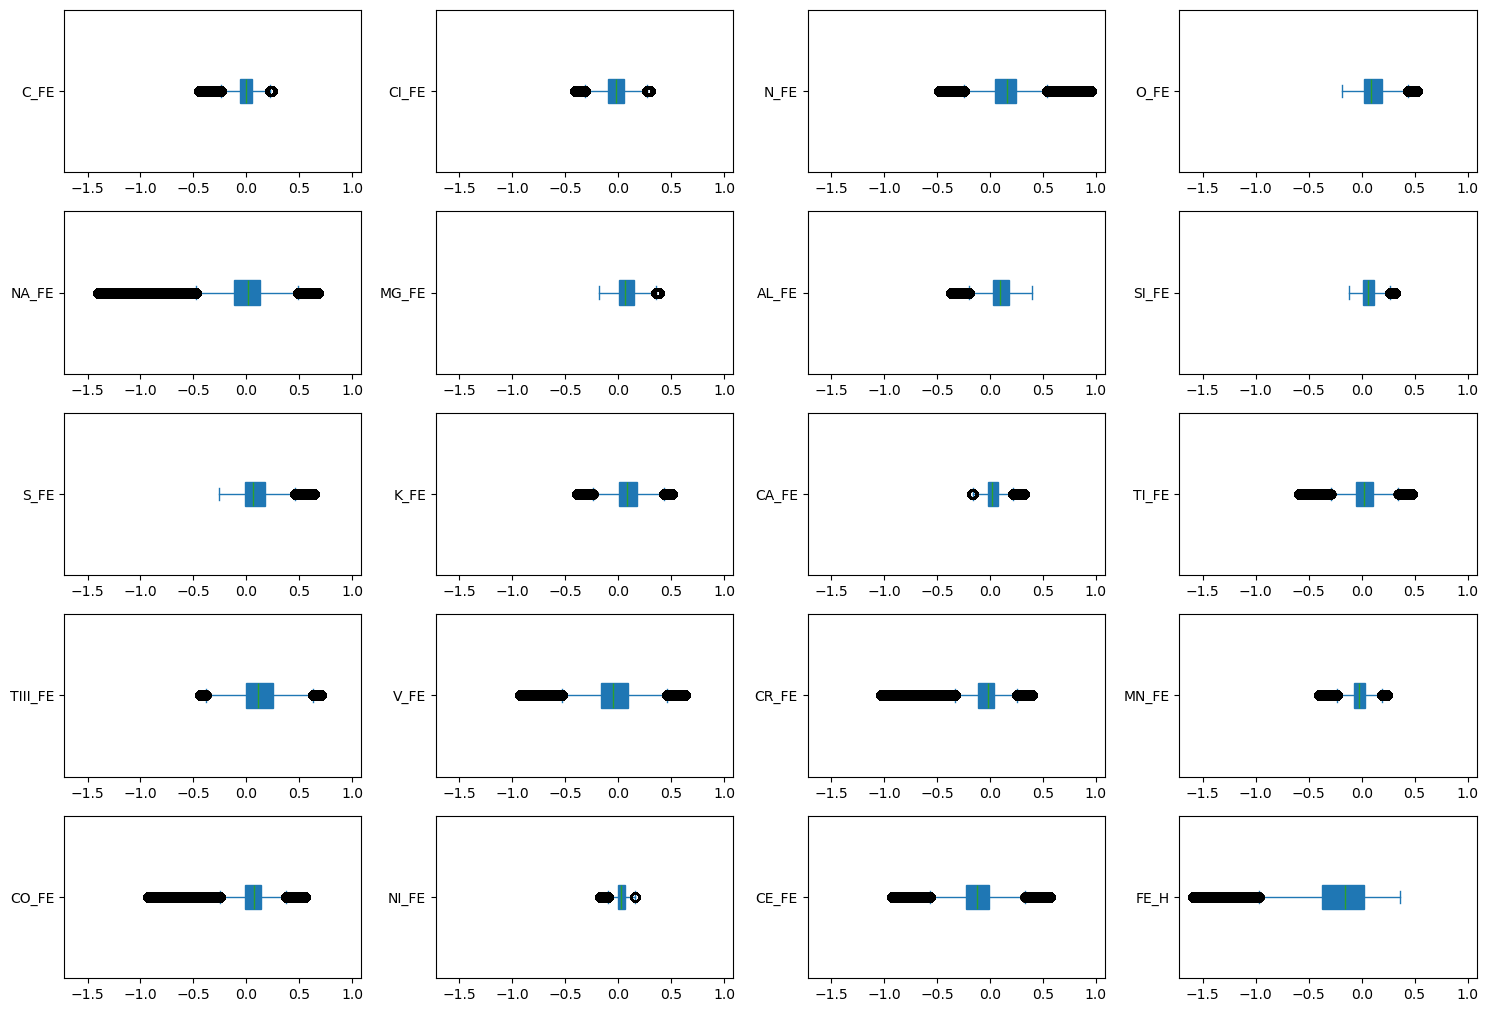

In [20]:
# Créer les boxplots en limitant les valeurs extrêmes
axes = chemical_subset_filtered.plot(kind='box', subplots=True, layout=(6, 4), figsize=(15, 12), patch_artist=True, vert=False)

# Si `axes` est une liste ou un tableau, on itère simplement dessus
for ax in axes:
    ax.xaxis.set_tick_params(labelbottom=True)  # Afficher les étiquettes des axes x
    ax.yaxis.set_tick_params(labelleft=True)    # Afficher les étiquettes des axes y

# Rotation des étiquettes pour les rendre lisibles
plt.xticks(rotation=45)

# Ajuster l'espacement des sous-graphiques
plt.tight_layout()

# Afficher les boxplots
plt.show()



## Violin plots (filtré)

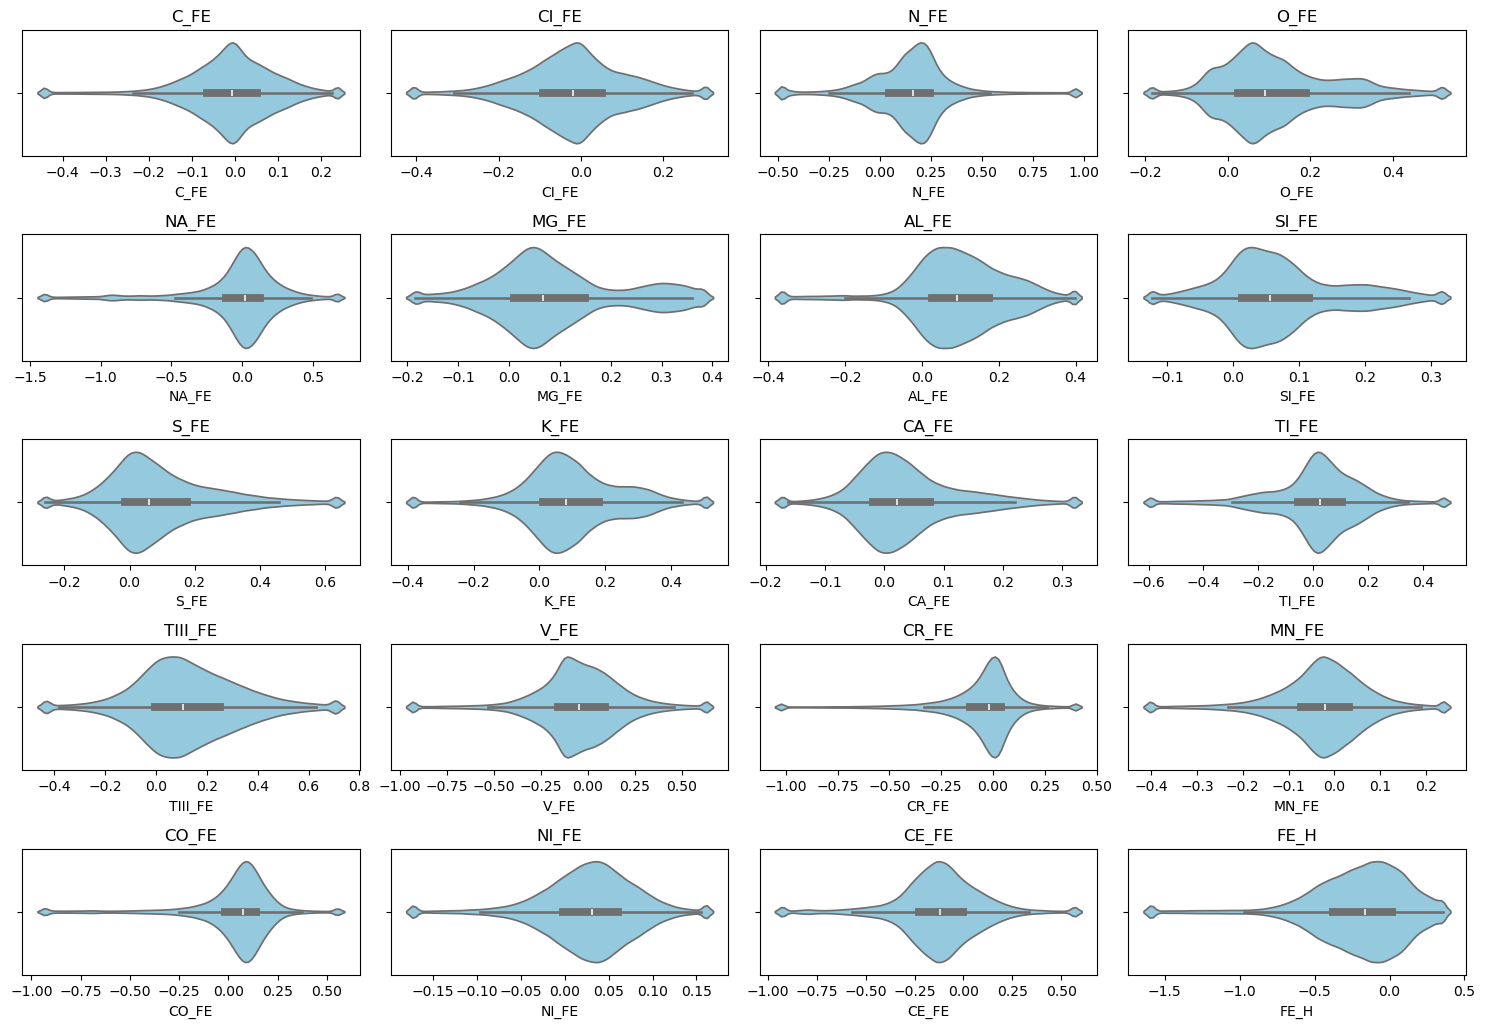

In [21]:
# Définir la taille de la figure
plt.figure(figsize=(15, 12))

# Créer un violin plot pour chaque colonne de chemical_subset
for i, column in enumerate(chemical_subset_filtered.columns, 1):
    plt.subplot(6, 4, i)
    sns.violinplot(x=chemical_subset_filtered[column], color='skyblue')
    plt.title(column)

# Ajuster l'espacement
plt.tight_layout()

# Afficher les violin plots
plt.show()


In [22]:
chemical_subset.corr(method='pearson', min_periods=1, numeric_only=True).style.background_gradient(cmap='coolwarm')

,C_FE,CI_FE,N_FE,O_FE,NA_FE,MG_FE,AL_FE,SI_FE,S_FE,K_FE,CA_FE,TI_FE,TIII_FE,V_FE,CR_FE,MN_FE,CO_FE,NI_FE,CE_FE,FE_H
C_FE,1.000000,0.763859,-0.173519,0.271995,0.032478,0.381462,0.385329,0.269950,0.122493,0.205774,0.089469,0.268458,0.138720,-0.004276,0.025026,0.047192,0.173556,0.337103,-0.087640,0.121930
CI_FE,0.763859,1.000000,-0.276681,0.426240,-0.025685,0.461503,0.397388,0.424530,0.262542,0.265000,0.231980,0.163491,0.232814,0.036844,-0.067109,-0.156063,0.100607,0.257232,-0.084624,-0.137943
N_FE,-0.173519,-0.276681,1.000000,-0.099138,0.122504,-0.093980,-0.057033,-0.045317,0.015300,-0.007251,-0.071824,0.126785,-0.089411,-0.012446,0.092262,0.126239,0.077203,0.003175,0.156169,0.002297
O_FE,0.271995,0.426240,-0.099138,1.000000,-0.013645,0.756523,0.278673,0.731164,0.537855,0.386639,0.501140,0.235392,0.394649,0.087362,-0.030403,-0.446561,0.023781,0.232882,-0.151311,-0.561467
NA_FE,0.032478,-0.025685,0.122504,-0.013645,1.000000,0.067440,0.016884,-0.003167,0.008384,0.060956,0.028691,0.107353,-0.049575,0.027318,0.132284,0.101452,0.123621,0.141889,-0.021495,0.058936
MG_FE,0.381462,0.461503,-0.093980,0.756523,0.067440,1.000000,0.429579,0.785199,0.597236,0.477981,0.576666,0.414558,0.446772,0.087257,0.064241,-0.417986,0.082701,0.338893,-0.158264,-0.515562
AL_FE,0.385329,0.397388,-0.057033,0.278673,0.016884,0.429579,1.000000,0.471637,0.139271,0.297168,0.296548,0.134284,0.297399,0.069398,-0.056231,-0.156045,0.041147,0.299601,-0.060663,-0.028705
SI_FE,0.269950,0.424530,-0.045317,0.731164,-0.003167,0.785199,0.471637,1.000000,0.532778,0.372125,0.504880,0.203009,0.432103,0.081281,-0.106145,-0.442128,0.045613,0.231398,-0.125006,-0.539591
S_FE,0.122493,0.262542,0.015300,0.537855,0.008384,0.597236,0.139271,0.532778,1.000000,0.363162,0.460322,0.225240,0.362968,0.038931,0.037686,-0.427887,0.017311,0.136345,-0.043365,-0.599353
K_FE,0.205774,0.265000,-0.007251,0.386639,0.060956,0.477981,0.297168,0.372125,0.363162,1.000000,0.413461,0.270630,0.310542,0.055241,0.079818,-0.250273,0.086612,0.191753,-0.098631,-0.348916


In [23]:
chemical_subset.corr(method='kendall', min_periods=1, numeric_only=True).style.background_gradient(cmap='coolwarm')

,C_FE,CI_FE,N_FE,O_FE,NA_FE,MG_FE,AL_FE,SI_FE,S_FE,K_FE,CA_FE,TI_FE,TIII_FE,V_FE,CR_FE,MN_FE,CO_FE,NI_FE,CE_FE,FE_H
C_FE,1.000000,0.605660,-0.155169,0.259258,0.069554,0.329592,0.276084,0.266381,0.202676,0.261136,0.126762,0.305521,0.145824,-0.002307,0.060233,-0.082641,0.243470,0.310710,-0.209156,-0.058905
CI_FE,0.605660,1.000000,-0.260776,0.330233,0.020154,0.319943,0.343266,0.353371,0.241687,0.275279,0.183735,0.175465,0.204581,0.032818,-0.050103,-0.203118,0.188309,0.230464,-0.163118,-0.195463
N_FE,-0.155169,-0.260776,1.000000,-0.113982,0.122594,-0.100571,-0.142040,-0.111302,-0.021444,-0.031063,-0.114364,0.037193,-0.130162,-0.054547,0.091036,0.184374,0.027841,0.022648,0.113338,0.095024
O_FE,0.259258,0.330233,-0.113982,1.000000,-0.043725,0.575647,0.303494,0.557584,0.400009,0.337307,0.391554,0.229006,0.328416,0.058295,-0.060052,-0.376713,0.113582,0.232726,-0.116262,-0.406996
NA_FE,0.069554,0.020154,0.122594,-0.043725,1.000000,0.014537,0.018927,-0.016673,-0.025071,0.038933,-0.028358,0.088016,-0.037881,0.004278,0.088783,0.131114,0.140892,0.142306,-0.078191,0.122288
MG_FE,0.329592,0.319943,-0.100571,0.575647,0.014537,1.000000,0.342985,0.536653,0.450083,0.406639,0.464811,0.358528,0.325338,0.058831,0.051101,-0.366365,0.135140,0.315723,-0.145798,-0.391444
AL_FE,0.276084,0.343266,-0.142040,0.303494,0.018927,0.342985,1.000000,0.467704,0.168744,0.292505,0.312055,0.130593,0.266472,0.089089,-0.096645,-0.248508,0.086870,0.227387,-0.084052,-0.206177
SI_FE,0.266381,0.353371,-0.111302,0.557584,-0.016673,0.536653,0.467704,1.000000,0.330321,0.301644,0.370410,0.160572,0.340923,0.083497,-0.141599,-0.346975,0.104204,0.226990,-0.114767,-0.364587
S_FE,0.202676,0.241687,-0.021444,0.400009,-0.025071,0.450083,0.168744,0.330321,1.000000,0.345714,0.370210,0.209217,0.316192,0.017813,0.018693,-0.358153,0.076475,0.153422,-0.029532,-0.459960
K_FE,0.261136,0.275279,-0.031063,0.337307,0.038933,0.406639,0.292505,0.301644,0.345714,1.000000,0.372732,0.284458,0.270607,0.040081,0.042804,-0.283981,0.144549,0.213197,-0.109315,-0.318791


In [24]:
chemical_subset.corr(method='spearman', min_periods=1, numeric_only=True).style.background_gradient(cmap='coolwarm')

,C_FE,CI_FE,N_FE,O_FE,NA_FE,MG_FE,AL_FE,SI_FE,S_FE,K_FE,CA_FE,TI_FE,TIII_FE,V_FE,CR_FE,MN_FE,CO_FE,NI_FE,CE_FE,FE_H
C_FE,1.000000,0.777880,-0.222275,0.376997,0.101339,0.475046,0.394897,0.385929,0.289811,0.374072,0.198959,0.435797,0.221683,-0.003854,0.086281,-0.131756,0.340324,0.438312,-0.294638,-0.094426
CI_FE,0.777880,1.000000,-0.372898,0.469899,0.029113,0.461308,0.482217,0.498569,0.351239,0.398277,0.283116,0.263012,0.303454,0.047735,-0.076132,-0.300466,0.261309,0.329434,-0.230678,-0.286284
N_FE,-0.222275,-0.372898,1.000000,-0.157911,0.169406,-0.132819,-0.203244,-0.161814,-0.024886,-0.039653,-0.157976,0.064537,-0.184167,-0.079654,0.132417,0.262416,0.043790,0.036756,0.161173,0.138345
O_FE,0.376997,0.469899,-0.157911,1.000000,-0.060559,0.740641,0.418838,0.729153,0.553137,0.476440,0.538241,0.328889,0.467509,0.087639,-0.086905,-0.529364,0.157564,0.330554,-0.167181,-0.580386
NA_FE,0.101339,0.029113,0.169406,-0.060559,1.000000,0.023598,0.030666,-0.020568,-0.035383,0.057038,-0.038107,0.123886,-0.053571,0.004375,0.124867,0.183176,0.195564,0.202549,-0.110432,0.173067
MG_FE,0.475046,0.461308,-0.132819,0.740641,0.023598,1.000000,0.476456,0.704770,0.615080,0.564055,0.628333,0.499677,0.469817,0.088782,0.075131,-0.517223,0.195576,0.444186,-0.210751,-0.568396
AL_FE,0.394897,0.482217,-0.203244,0.418838,0.030666,0.476456,1.000000,0.611232,0.244712,0.415707,0.426971,0.198817,0.385038,0.129092,-0.141284,-0.342564,0.128726,0.324792,-0.120808,-0.284270
SI_FE,0.385929,0.498569,-0.161814,0.729153,-0.020568,0.704770,0.611232,1.000000,0.470915,0.437158,0.514054,0.243364,0.486890,0.121940,-0.205958,-0.492371,0.151006,0.324136,-0.165423,-0.521503
S_FE,0.289811,0.351239,-0.024886,0.553137,-0.035383,0.615080,0.244712,0.470915,1.000000,0.489629,0.521214,0.302652,0.447401,0.028980,0.031573,-0.504961,0.108869,0.221215,-0.044374,-0.638342
K_FE,0.374072,0.398277,-0.039653,0.476440,0.057038,0.564055,0.415707,0.437158,0.489629,1.000000,0.520969,0.407339,0.391390,0.059550,0.061902,-0.407823,0.207294,0.305651,-0.159906,-0.460271


In [25]:
chemical_subset.describe()

,C_FE,CI_FE,N_FE,O_FE,NA_FE,MG_FE,AL_FE,SI_FE,S_FE,K_FE,CA_FE,TI_FE,TIII_FE,V_FE,CR_FE,MN_FE,CO_FE,NI_FE,CE_FE,FE_H
count,568858.000000,567211.000000,522468.000000,569357.000000,513785.000000,570301.000000,519828.000000,570339.000000,510046.000000,563336.000000,560678.000000,532833.000000,330471.000000,494857.000000,517737.000000,529015.000000,345273.000000,567455.000000,322888.000000,570469.000000
mean,-0.013171,-0.020690,0.149272,0.116297,-0.041405,0.089888,0.097001,0.070696,0.093627,0.095301,0.035836,0.011748,0.125799,-0.045172,-0.063645,-0.027310,0.030104,0.026544,-0.125528,-0.211297
std,0.119636,0.136561,0.223473,0.144456,0.354434,0.130365,0.140900,0.094126,0.173759,0.183924,0.100825,0.178950,0.213815,0.260985,0.230900,0.119493,0.247764,0.069428,0.255753,0.351805
min,-1.781700,-2.167200,-2.000460,-1.319637,-2.711926,-1.602991,-2.566144,-1.302277,-1.380307,-2.708927,-1.476114,-1.494771,-0.962971,-2.651900,-3.050162,-2.444148,-2.981460,-2.930750,-2.510510,-2.468600
25%,-0.064475,-0.092142,0.047192,0.025042,-0.112538,0.010176,0.025181,0.013019,-0.013103,0.011813,-0.018707,-0.053797,-0.003502,-0.158008,-0.110366,-0.073597,-0.015430,-0.001837,-0.229409,-0.377480
50%,-0.007206,-0.019142,0.163610,0.089560,0.016820,0.066161,0.092574,0.055606,0.060094,0.081959,0.021262,0.025186,0.108139,-0.045856,-0.019626,-0.020738,0.072940,0.030612,-0.119860,-0.160870
75%,0.051055,0.052586,0.243790,0.190141,0.126942,0.149818,0.175548,0.114345,0.175402,0.180309,0.076867,0.106719,0.249739,0.088572,0.037124,0.031372,0.140850,0.060910,-0.003950,0.017488
max,1.152312,1.161671,2.791340,1.289533,2.816742,1.196283,2.561891,1.434180,1.749402,2.711989,1.331946,1.295149,1.211749,2.964442,2.283114,2.683733,2.853850,2.399333,2.806300,0.954290


In [26]:
# moyenne, écart-type, minimum, maximum, 1er quartile, médiane, 3e quartile
summary = chemical_subset.describe().loc[['mean', 'std', 'min', 'max', '25%', '50%', '75%']]
summary

,C_FE,CI_FE,N_FE,O_FE,NA_FE,MG_FE,AL_FE,SI_FE,S_FE,K_FE,CA_FE,TI_FE,TIII_FE,V_FE,CR_FE,MN_FE,CO_FE,NI_FE,CE_FE,FE_H
mean,-0.013171,-0.020690,0.149272,0.116297,-0.041405,0.089888,0.097001,0.070696,0.093627,0.095301,0.035836,0.011748,0.125799,-0.045172,-0.063645,-0.027310,0.030104,0.026544,-0.125528,-0.211297
std,0.119636,0.136561,0.223473,0.144456,0.354434,0.130365,0.140900,0.094126,0.173759,0.183924,0.100825,0.178950,0.213815,0.260985,0.230900,0.119493,0.247764,0.069428,0.255753,0.351805
min,-1.781700,-2.167200,-2.000460,-1.319637,-2.711926,-1.602991,-2.566144,-1.302277,-1.380307,-2.708927,-1.476114,-1.494771,-0.962971,-2.651900,-3.050162,-2.444148,-2.981460,-2.930750,-2.510510,-2.468600
max,1.152312,1.161671,2.791340,1.289533,2.816742,1.196283,2.561891,1.434180,1.749402,2.711989,1.331946,1.295149,1.211749,2.964442,2.283114,2.683733,2.853850,2.399333,2.806300,0.954290
25%,-0.064475,-0.092142,0.047192,0.025042,-0.112538,0.010176,0.025181,0.013019,-0.013103,0.011813,-0.018707,-0.053797,-0.003502,-0.158008,-0.110366,-0.073597,-0.015430,-0.001837,-0.229409,-0.377480
50%,-0.007206,-0.019142,0.163610,0.089560,0.016820,0.066161,0.092574,0.055606,0.060094,0.081959,0.021262,0.025186,0.108139,-0.045856,-0.019626,-0.020738,0.072940,0.030612,-0.119860,-0.160870
75%,0.051055,0.052586,0.243790,0.190141,0.126942,0.149818,0.175548,0.114345,0.175402,0.180309,0.076867,0.106719,0.249739,0.088572,0.037124,0.031372,0.140850,0.060910,-0.003950,0.017488


In [27]:
list(chemical_subset.columns)

['C_FE',
 'CI_FE',
 'N_FE',
 'O_FE',
 'NA_FE',
 'MG_FE',
 'AL_FE',
 'SI_FE',
 'S_FE',
 'K_FE',
 'CA_FE',
 'TI_FE',
 'TIII_FE',
 'V_FE',
 'CR_FE',
 'MN_FE',
 'CO_FE',
 'NI_FE',
 'CE_FE',
 'FE_H']

In [28]:
variable_selection = ['apogee_id', "J", "H", "K","LOGG", "M_H", "VMICRO", "VMACRO", "VSINI", 'C_FE', 'CI_FE', 'N_FE', 'O_FE', 'NA_FE', 'MG_FE', 'AL_FE', 'SI_FE', 'S_FE', 'K_FE', 'CA_FE', 
    'TI_FE', 'TIII_FE', 'V_FE', 'CR_FE', 'MN_FE', 'CO_FE', 'NI_FE', 'CE_FE', 'FE_H', 
    'class_spectral', 'class_lum_logg', 'class_lum_jhk', 'class_lum_bins_logg', 'class_lum_bins_jhk']

In [29]:
sample = df[variable_selection]

In [30]:
print("nombre de lignes du dataset sample : ", sample.shape[0])

nombre de lignes du dataset sample :  594011


In [31]:
sample.head()

,apogee_id,J,H,K,LOGG,M_H,VMICRO,VMACRO,VSINI,C_FE,...,MN_FE,CO_FE,NI_FE,CE_FE,FE_H,class_spectral,class_lum_logg,class_lum_jhk,class_lum_bins_logg,class_lum_bins_jhk
0,2M00000019-1924498,11.074,10.740,10.670,4.304115,-0.26875,0.409694,0.000000,6.273645,0.061738,...,-0.078027,NaN,0.013930,NaN,-0.27553,G,V,Ia,7,3
1,2M00000032+5737103,10.905,10.635,10.483,3.673970,-0.24510,2.143433,0.000000,14.965801,0.112730,...,0.063633,NaN,-0.108750,NaN,-0.25297,F,V,II,6,3
2,2M00000032+5737103,10.905,10.635,10.483,3.673970,-0.24510,2.143433,0.000000,14.965801,0.112730,...,0.063633,NaN,-0.108750,NaN,-0.25297,F,V,II,6,3
3,2M00000068+5710233,10.664,10.132,10.018,3.456132,-0.16008,0.671970,3.246955,NaN,-0.025731,...,-0.029748,-0.26304,0.059073,-0.05558,-0.16028,K,IV,II,5,3
4,2M00000103+1525513,11.278,11.006,10.947,4.123192,-0.26704,0.459484,0.000000,6.752274,0.049917,...,0.058733,NaN,-0.037420,NaN,-0.26189,G,V,III,6,4


In [32]:
# Check for missing values
missing_values = sample.isnull().sum()

In [33]:
# Ordonner la liste des valeurs manquantes dans l'ordre croissant
missing_values_sorted = missing_values.sort_values()
print("Nombre de valeurs manquantes dans chaque colonne (ordre croissant):\n", missing_values_sorted)

Nombre de valeurs manquantes dans chaque colonne (ordre croissant):
 apogee_id                   0
class_lum_jhk               0
class_lum_logg              0
class_spectral              0
class_lum_bins_logg         0
VMACRO                      0
class_lum_bins_jhk          0
J                           0
H                           0
K                           0
VMICRO                      0
LOGG                        0
FE_H                    23542
M_H                     23581
SI_FE                   23672
MG_FE                   23710
O_FE                    24654
C_FE                    25153
NI_FE                   26556
CI_FE                   26800
K_FE                    30675
CA_FE                   33333
TI_FE                   61178
MN_FE                   64996
N_FE                    71543
AL_FE                   74183
CR_FE                   76274
NA_FE                   80226
S_FE                    83965
V_FE                    99154
CO_FE                  248738
T

In [34]:
missing_values_dropable = missing_values[missing_values > sample.shape[0]/4]

In [35]:
missing_values_dropable

VSINI      318023
TIII_FE    263540
CO_FE      248738
CE_FE      271123
dtype: int64

In [36]:
missing_values_dropable

VSINI      318023
TIII_FE    263540
CO_FE      248738
CE_FE      271123
dtype: int64

In [37]:
sample = sample.drop(columns=["VSINI", "TIII_FE", "CO_FE", "CE_FE"])

In [38]:
# Number of rows with any missing values
num_rows_with_missing = sample.isnull().any(axis=1).sum()
print("Number of rows with missing values:", num_rows_with_missing, "/", sample.shape[0])

Number of rows with missing values: 140059 / 594011


In [39]:
print("Nombre de colonnes du dataset sample : ", sample.shape[1])

Nombre de colonnes du dataset sample :  30


In [40]:
missing_per_row = sample.isna().sum(axis=1)

In [41]:
missing_per_row.sort_values()

0          0
377130     0
377129     0
377128     0
377127     0
          ..
506243    18
71366     18
71355     18
218349    18
424776    18
Length: 594011, dtype: int64

In [42]:
print("Nombre de valeurs manquantes par ligne (ordre croissant):\n", missing_per_row.sort_values())

Nombre de valeurs manquantes par ligne (ordre croissant):
 0          0
377130     0
377129     0
377128     0
377127     0
          ..
506243    18
71366     18
71355     18
218349    18
424776    18
Length: 594011, dtype: int64


In [43]:
#compte le nombre de ligne par nombre de valeurs manquantes
# trié par ordre croissant
missing_per_row.value_counts().sort_index()

0     453952
1      41613
2      12857
3       9626
4       1326
5       5323
6      19024
7      16752
8        283
9       9484
10       206
11        15
12         5
13         3
17        37
18     23505
Name: count, dtype: int64

In [44]:
missing_per_row = missing_per_row[missing_per_row > 0]

In [45]:
#compte le nombre de ligne par nombre de valeurs manquantes
# trié par ordre croissant
missing_per_row.value_counts().sort_index()

1     41613
2     12857
3      9626
4      1326
5      5323
6     19024
7     16752
8       283
9      9484
10      206
11       15
12        5
13        3
17       37
18    23505
Name: count, dtype: int64

In [46]:
#créer un dataset qui contient les lignes sans valeurs manquantes
sample_0_miss = sample.dropna()

In [47]:
#créer un dataset qui contient les lignes avec 1 valeur manquante ou moins
sample_1_miss = sample[sample.isna().sum(axis=1) == 1]
sample_1_miss = pd.concat([sample_1_miss, sample_0_miss])

In [48]:
#créer un dataset qui contient les lignes avec 2 valeurs manquantes ou moins
sample_2_miss = sample[sample.isna().sum(axis=1) == 2]
sample_2_miss = pd.concat([sample_2_miss, sample_1_miss])

In [49]:
#créer un dataset qui contient les lignes avec 3 valeurs manquantes ou moins
sample_3_miss = sample[sample.isna().sum(axis=1) == 3]
sample_3_miss = pd.concat([sample_3_miss, sample_2_miss])

In [50]:
sample_0_miss

,apogee_id,J,H,K,LOGG,M_H,VMICRO,VMACRO,C_FE,CI_FE,...,V_FE,CR_FE,MN_FE,NI_FE,FE_H,class_spectral,class_lum_logg,class_lum_jhk,class_lum_bins_logg,class_lum_bins_jhk
0,2M00000019-1924498,11.074,10.740,10.670,4.304115,-0.268750,0.409694,0.000000,0.061738,0.070630,...,0.050501,-0.130982,-0.078027,0.013930,-0.275530,G,V,Ia,7,3
1,2M00000032+5737103,10.905,10.635,10.483,3.673970,-0.245100,2.143433,0.000000,0.112730,0.124440,...,-0.005469,-1.112472,0.063633,-0.108750,-0.252970,F,V,II,6,3
2,2M00000032+5737103,10.905,10.635,10.483,3.673970,-0.245100,2.143433,0.000000,0.112730,0.124440,...,-0.005469,-1.112472,0.063633,-0.108750,-0.252970,F,V,II,6,3
3,2M00000068+5710233,10.664,10.132,10.018,3.456132,-0.160080,0.671970,3.246955,-0.025731,-0.048319,...,0.202498,0.028904,-0.029748,0.059073,-0.160280,K,IV,II,5,3
5,2M00000133+5721163,13.261,12.605,12.383,2.388251,-0.513140,1.644599,3.991985,-0.069177,-0.124750,...,-0.097508,-0.206866,-0.107198,0.022393,-0.509530,K,III,Ib,3,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
594006,2M23595837+5700444,12.657,11.992,11.840,2.474665,-0.336430,1.588876,3.599870,-0.096586,-0.149370,...,-0.010078,-0.078846,0.020022,-0.015788,-0.333100,K,III,II,3,5
594007,2M23595846+1503028,11.288,10.865,10.787,4.538214,0.019167,0.737259,0.000000,-0.060003,-0.041190,...,-0.235866,0.081601,0.038055,0.005773,0.023937,G,V,III,7,4
594008,2M23595886+5726058,11.466,10.805,10.590,2.480687,-0.229250,1.557435,3.381057,-0.060314,-0.099930,...,0.195646,0.038944,-0.000038,0.022203,-0.236560,K,III,II,3,4
594009,2M23595921+5609479,11.985,11.363,11.226,2.571437,0.119920,1.212665,2.756312,-0.011308,-0.070493,...,-0.155308,0.024764,0.036437,0.032992,0.114820,K,III,II,3,4


<Axes: title={'center': '3 valeurs manquantes'}, xlabel='class_spectral'>

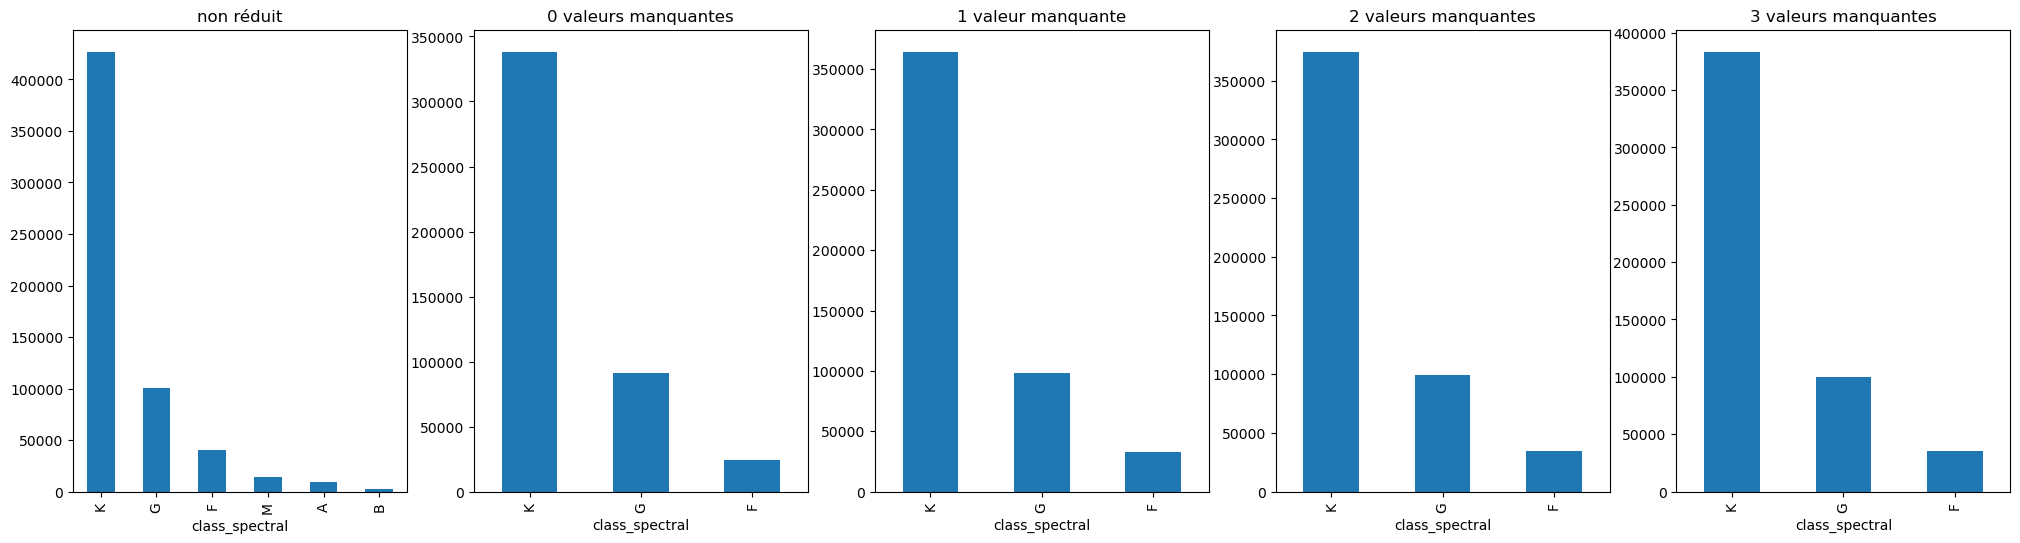

In [60]:
fig, axs = plt.subplots(1, 5, figsize=(25, 6))

sample['class_spectral'].value_counts().plot(kind='bar', ax=axs[0], title='non réduit')
sample_0_miss['class_spectral'].value_counts().plot(kind='bar', ax=axs[1], title='0 valeurs manquantes')
sample_1_miss['class_spectral'].value_counts().plot(kind='bar', ax=axs[2], title='1 valeur manquante')
sample_2_miss['class_spectral'].value_counts().plot(kind='bar', ax=axs[3], title='2 valeurs manquantes')
sample_3_miss['class_spectral'].value_counts().plot(kind='bar', ax=axs[4], title='3 valeurs manquantes')

<Axes: title={'center': '3 valeurs manquantes'}, xlabel='class_lum_logg'>

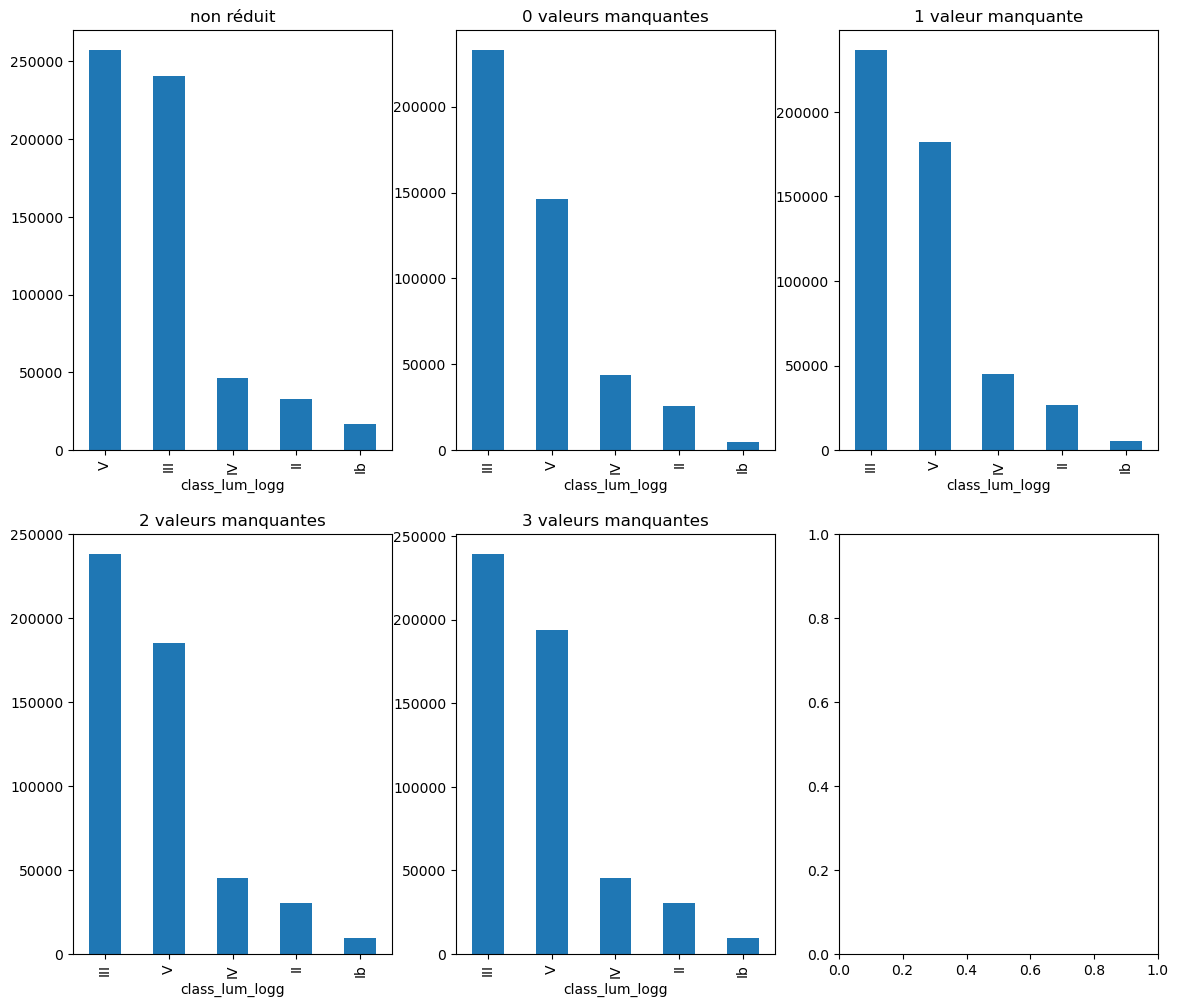

In [52]:
fig, axs = plt.subplots(2, 3, figsize=(14, 12))

sample['class_lum_logg'].value_counts().plot(kind='bar', ax=axs[0, 0], title='non réduit')
sample_0_miss['class_lum_logg'].value_counts().plot(kind='bar', ax=axs[0, 1], title='0 valeurs manquantes')
sample_1_miss['class_lum_logg'].value_counts().plot(kind='bar', ax=axs[0, 2], title='1 valeur manquante')
sample_2_miss['class_lum_logg'].value_counts().plot(kind='bar', ax=axs[1, 0], title='2 valeurs manquantes')
sample_3_miss['class_lum_logg'].value_counts().plot(kind='bar', ax=axs[1, 1], title='3 valeurs manquantes')

<Axes: title={'center': '3 valeurs manquantes'}, xlabel='class_lum_jhk'>

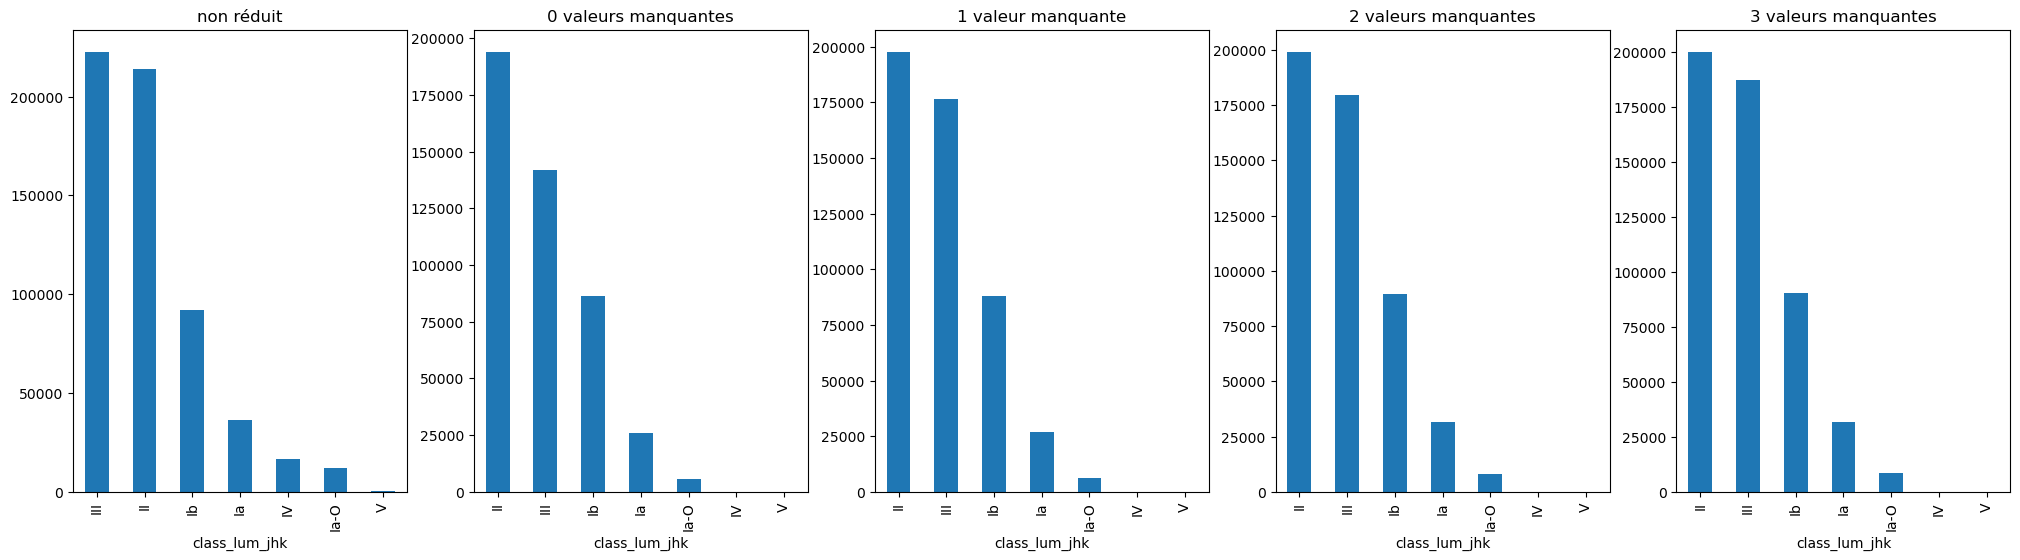

In [61]:
fig, axs = plt.subplots(1, 5, figsize=(25, 6))

sample['class_lum_jhk'].value_counts().plot(kind='bar', ax=axs[0], title='non réduit')
sample_0_miss['class_lum_jhk'].value_counts().plot(kind='bar', ax=axs[1], title='0 valeurs manquantes')
sample_1_miss['class_lum_jhk'].value_counts().plot(kind='bar', ax=axs[2], title='1 valeur manquante')
sample_2_miss['class_lum_jhk'].value_counts().plot(kind='bar', ax=axs[3], title='2 valeurs manquantes')
sample_3_miss['class_lum_jhk'].value_counts().plot(kind='bar', ax=axs[4], title='3 valeurs manquantes')

<Axes: title={'center': '3 valeurs manquantes'}, xlabel='class_lum_bins_logg'>

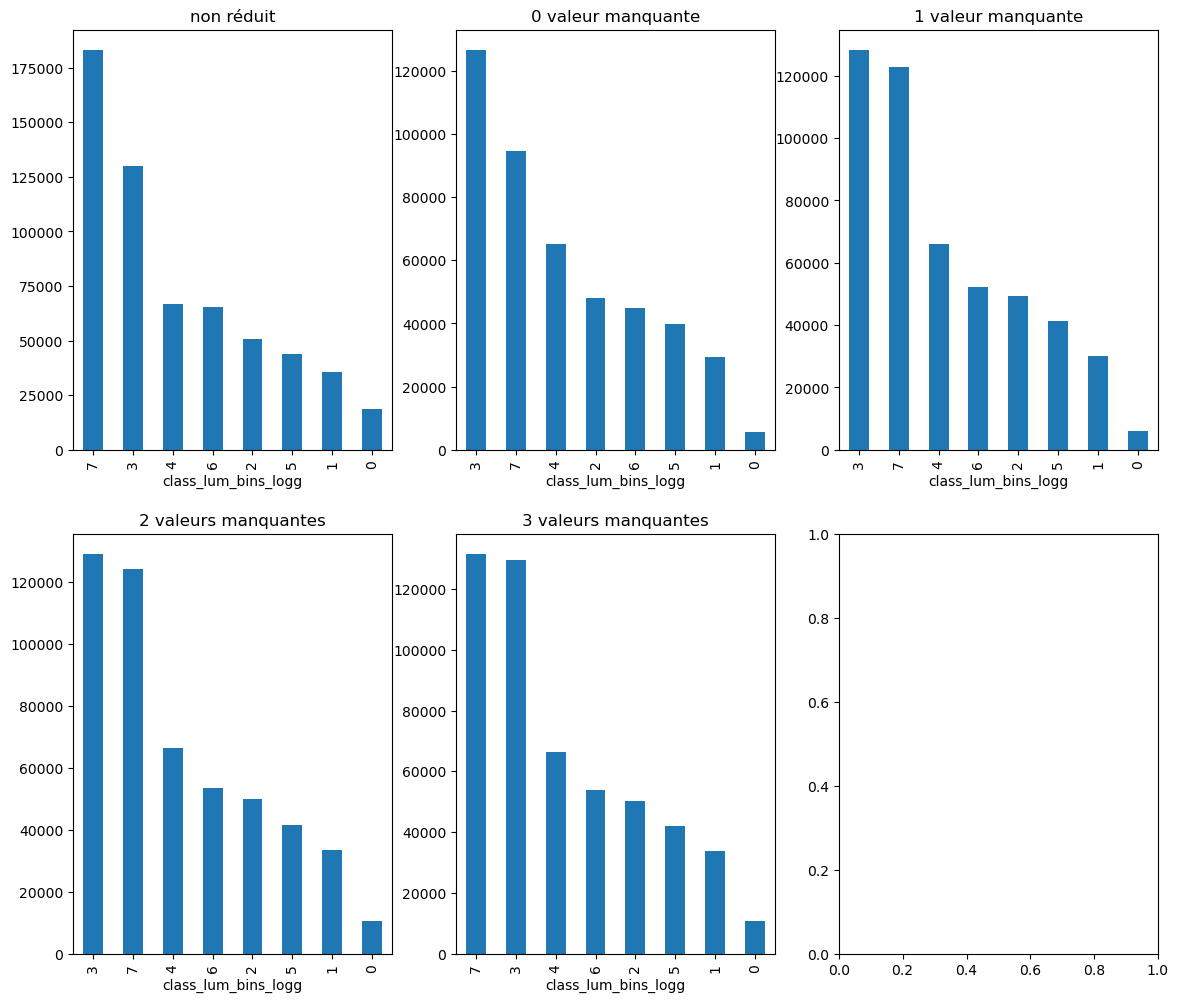

In [54]:
fig, axs = plt.subplots(2, 3, figsize=(14, 12))

sample['class_lum_bins_logg'].value_counts().plot(kind='bar', ax=axs[0, 0], title='non réduit')
sample_0_miss['class_lum_bins_logg'].value_counts().plot(kind='bar', ax=axs[0, 1], title='0 valeur manquante')
sample_1_miss['class_lum_bins_logg'].value_counts().plot(kind='bar', ax=axs[0, 2], title='1 valeur manquante')
sample_2_miss['class_lum_bins_logg'].value_counts().plot(kind='bar', ax=axs[1, 0], title='2 valeurs manquantes')
sample_3_miss['class_lum_bins_logg'].value_counts().plot(kind='bar', ax=axs[1, 1], title='3 valeurs manquantes')

<Axes: title={'center': '3 valeurs manquantes'}, xlabel='class_lum_bins_jhk'>

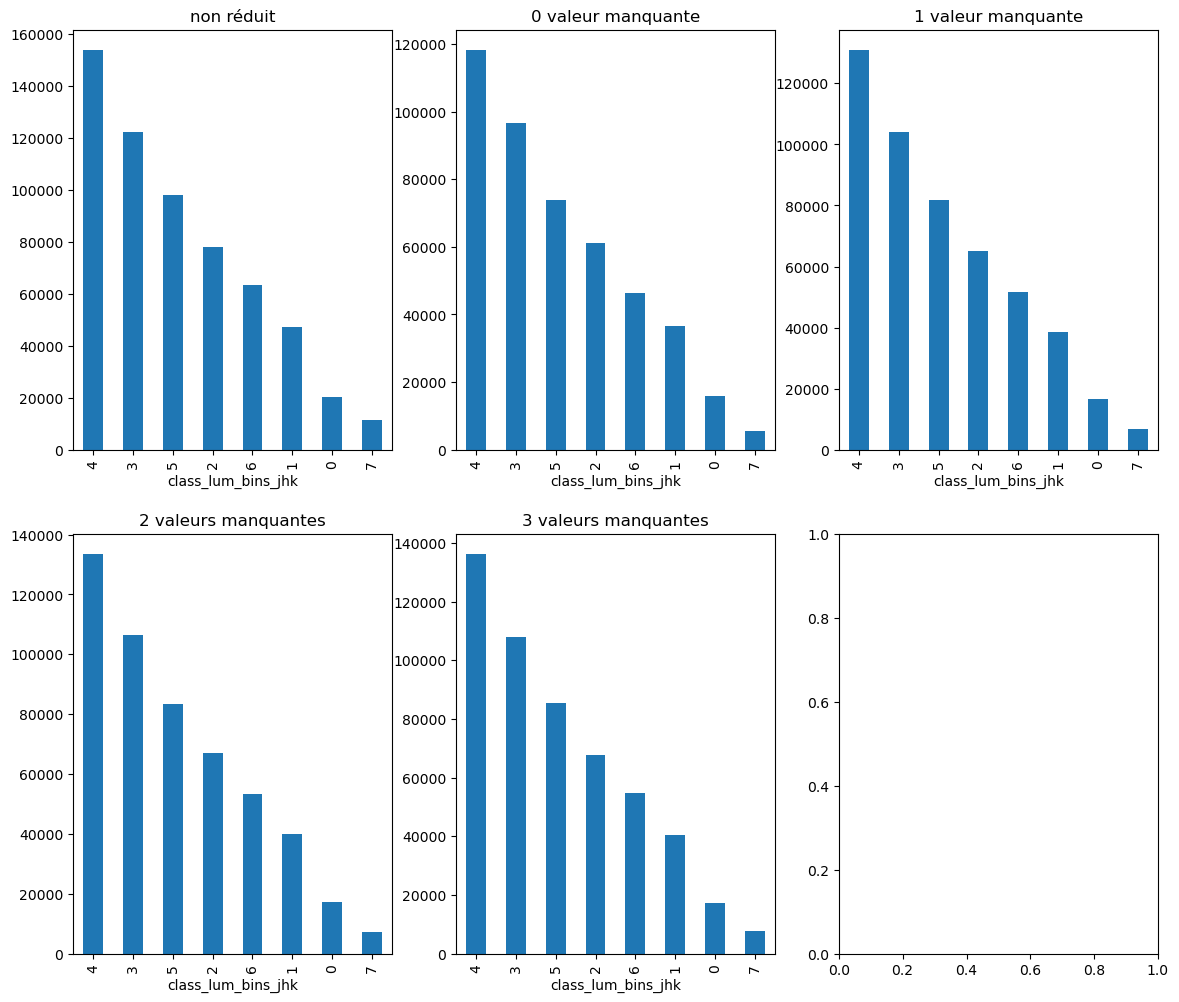

In [55]:
fig, axs = plt.subplots(2, 3, figsize=(14, 12))

sample['class_lum_bins_jhk'].value_counts().plot(kind='bar', ax=axs[0, 0], title='non réduit')
sample_0_miss['class_lum_bins_jhk'].value_counts().plot(kind='bar', ax=axs[0, 1], title='0 valeur manquante')
sample_1_miss['class_lum_bins_jhk'].value_counts().plot(kind='bar', ax=axs[0, 2], title='1 valeur manquante')
sample_2_miss['class_lum_bins_jhk'].value_counts().plot(kind='bar', ax=axs[1, 0], title='2 valeurs manquantes')
sample_3_miss['class_lum_bins_jhk'].value_counts().plot(kind='bar', ax=axs[1, 1], title='3 valeurs manquantes')

TODO : 
- match retrait colonne X lignes (done)
- différents tresholds lignes (done)
- pourcentagne de chaque classes pour chaques dataset (done)

Text(0.5, 0, 'class_lum_jhk')

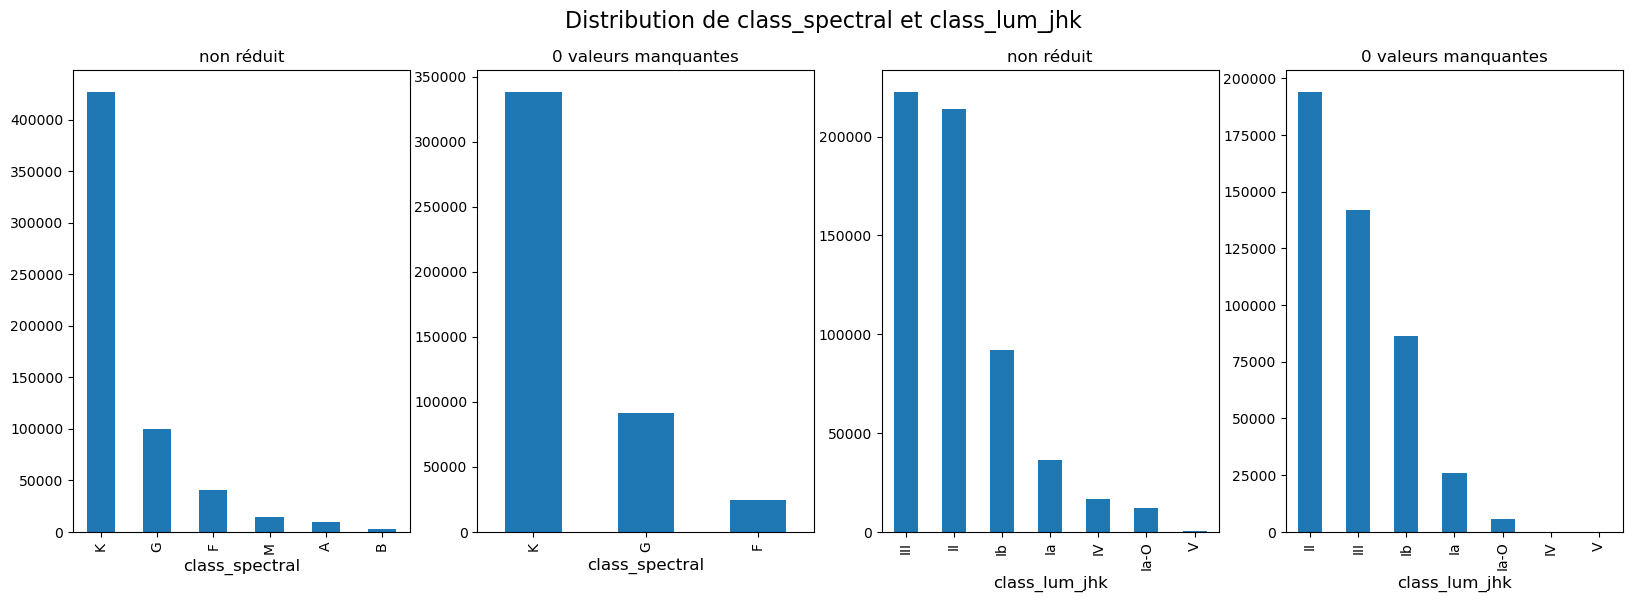

In [56]:
fig, axs = plt.subplots(1, 4, figsize=(20, 6))

fig.suptitle('Distribution de class_spectral et class_lum_jhk', fontsize=16)

sample['class_spectral'].value_counts().plot(kind='bar', ax=axs[0], title='non réduit')
sample_0_miss['class_spectral'].value_counts().plot(kind='bar', ax=axs[1], title='0 valeurs manquantes')

sample['class_lum_jhk'].value_counts().plot(kind='bar', ax=axs[2], title='non réduit')
sample_0_miss['class_lum_jhk'].value_counts().plot(kind='bar', ax=axs[3], title='0 valeurs manquantes')

#aggrandir la taille noms des axes x pour chaques figures
axs[0].set_xlabel('class_spectral', fontsize=12)
axs[1].set_xlabel('class_spectral', fontsize=12)
axs[2].set_xlabel('class_lum_jhk', fontsize=12)
axs[3].set_xlabel('class_lum_jhk', fontsize=12)

In [ ]:
import pandas as pd
import umap.umap_ as umap
import matplotlib.pyplot as plt
import seaborn as sns

# Supposez que votre DataFrame s'appelle sample_0_miss
# et contient toutes les colonnes listées ci-dessous.

# 1. Sélection des colonnes d'intérêt
features = [
    'C_FE', 'CI_FE', 'N_FE', 'O_FE', 'NA_FE',
    'MG_FE', 'AL_FE', 'SI_FE', 'S_FE', 'K_FE', 'CA_FE', 'TI_FE', 'V_FE',
    'CR_FE', 'MN_FE', 'NI_FE', 'FE_H'
]

X = sample_0_miss_umap[features]               # Variables utilisées pour UMAP
y = sample_0_miss_umap["class_combined_spec_jhk"]       # Variable pour colorer les points


In [ ]:

# 2. Instanciation et application d'UMAP
#    Ajustez éventuellement n_neighbors, min_dist, etc. selon vos besoins
reducer = umap.UMAP(n_neighbors=15, 
                    min_dist=0.3, 
                    n_components=2,
                    metric="euclidean",
                    verbose=True)

X_embedded = reducer.fit_transform(X)



UMAP(min_dist=0.3, verbose=True)
Thu Feb  6 10:58:59 2025 Construct fuzzy simplicial set
Thu Feb  6 10:58:59 2025 Finding Nearest Neighbors
Thu Feb  6 10:58:59 2025 Building RP forest with 10 trees
Thu Feb  6 10:58:59 2025 NN descent for 13 iterations
	 1  /  13
	 2  /  13
	 3  /  13
	 4  /  13
	Stopping threshold met -- exiting after 4 iterations
Thu Feb  6 10:59:00 2025 Finished Nearest Neighbor Search
Thu Feb  6 10:59:00 2025 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Thu Feb  6 10:59:21 2025 Finished embedding


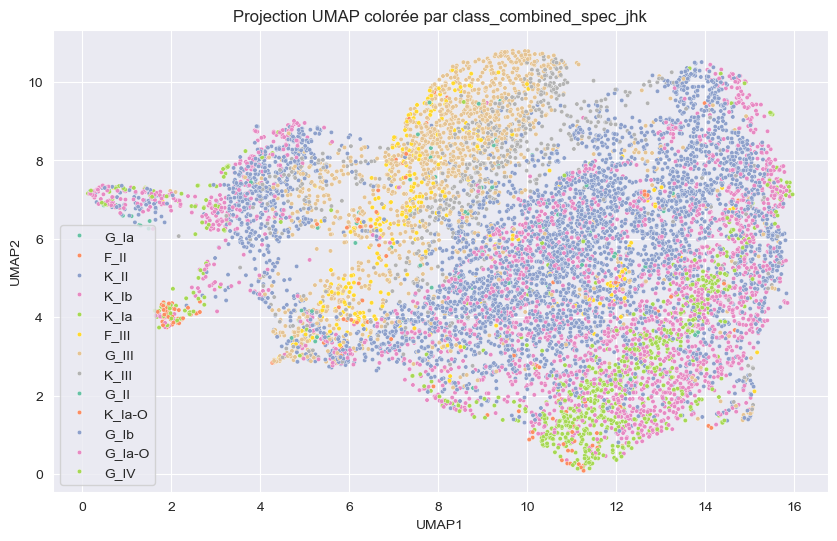

In [ ]:
# 3. Création d'un DataFrame pour faciliter l'affichage
df_umap = pd.DataFrame({
    'UMAP1': X_embedded[:,0],
    'UMAP2': X_embedded[:,1],
    'class_combined_spec_jhk': y
})

# 4. Visualisation en 2D
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_umap, 
                x='UMAP1', 
                s=10,
                y='UMAP2', 
                hue='class_combined_spec_jhk', 
                palette='Set2')
plt.title("Projection UMAP colorée par class_combined_spec_jhk")
plt.legend(loc='best')
plt.show()


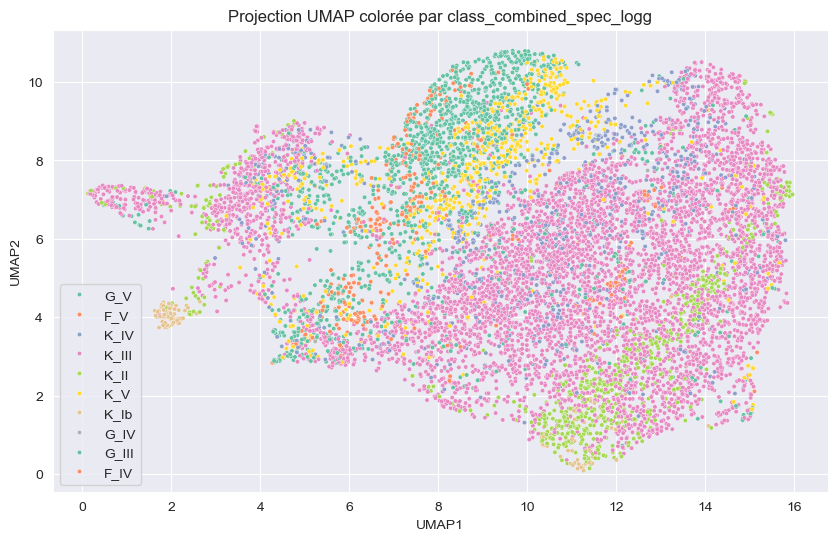

In [ ]:

y = sample_0_miss_umap["class_combined_spec_logg"]
# 3. Création d'un DataFrame pour faciliter l'affichage
df_umap = pd.DataFrame({
    'UMAP1': X_embedded[:,0],
    'UMAP2': X_embedded[:,1],
    'class_combined_spec_logg': y
})

# 4. Visualisation en 2D
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_umap, 
                x='UMAP1', 
                s=10,
                y='UMAP2', 
                hue='class_combined_spec_logg', 
                palette='Set2')
plt.title("Projection UMAP colorée par class_combined_spec_logg")
plt.legend(loc='best')
plt.show()


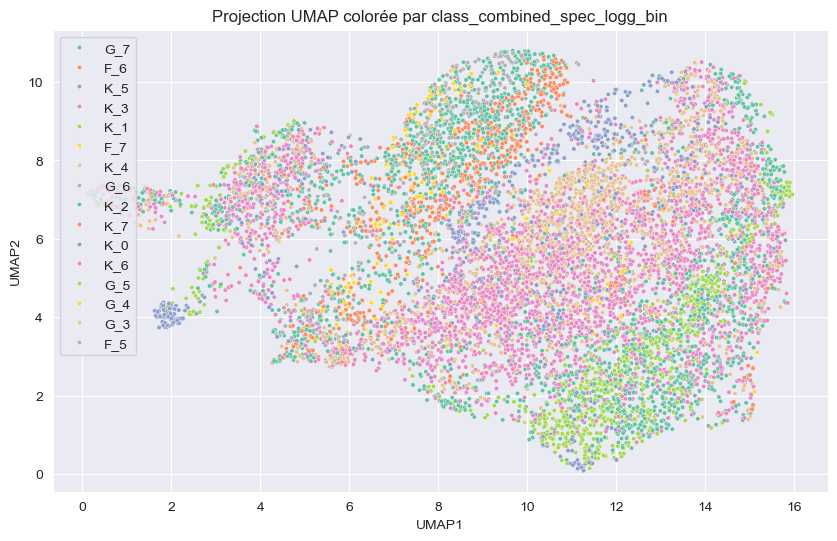

In [ ]:
y = sample_0_miss_umap["class_combined_spec_logg_bin"]  
# 3. Création d'un DataFrame pour faciliter l'affichage
df_umap = pd.DataFrame({
    'UMAP1': X_embedded[:,0],
    'UMAP2': X_embedded[:,1],
    'class_combined_spec_logg_bin': y
})

# 4. Visualisation en 2D
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_umap, 
                x='UMAP1', 
                s=10,
                y='UMAP2', 
                hue='class_combined_spec_logg_bin', 
                palette='Set2')
plt.title("Projection UMAP colorée par class_combined_spec_logg_bin")
plt.legend(loc='best')
plt.show()


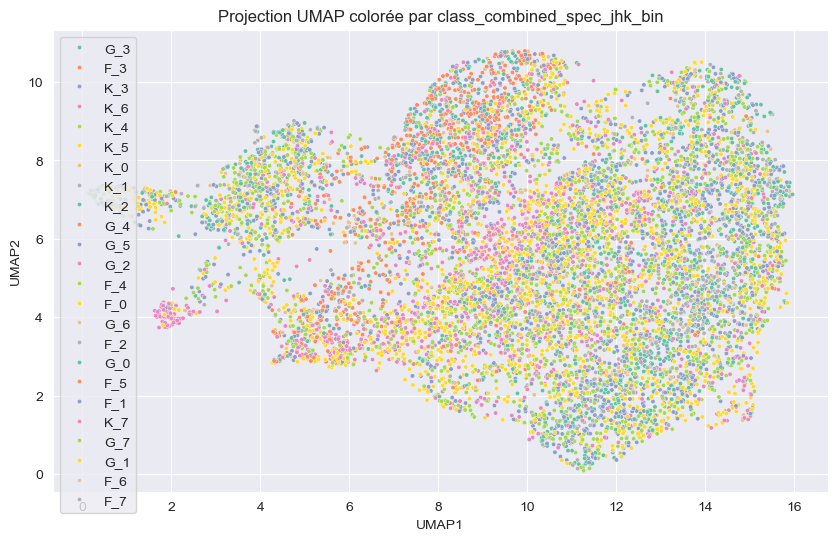

In [ ]:
y = sample_0_miss_umap["class_combined_spec_jhk_bin"]  
# 3. Création d'un DataFrame pour faciliter l'affichage
df_umap = pd.DataFrame({
    'UMAP1': X_embedded[:,0],
    'UMAP2': X_embedded[:,1],
    'class_combined_spec_jhk_bin': y
})

# 4. Visualisation en 2D
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_umap, 
                x='UMAP1', 
                s=10,
                y='UMAP2', 
                hue='class_combined_spec_jhk_bin', 
                palette='Set2')
plt.title("Projection UMAP colorée par class_combined_spec_jhk_bin")
plt.legend(loc='best')
plt.show()
